# A simple example on how to use `scopes`

In this tutorial you will learn the basic functionality of scopes and how to set everything up to use it.

## Topics

- Construct the "Night" object to designate the specific night of the year for which the schedule is to be created.
- Establish the observing programs, outlining their specific objectives and parameters.
- Determine the merits to be utilized, ensuring they align with the objectives of the observing programs.
- Create the "Target" objects, assigning appropriate merits based on the unique requirements of each target.
- Create the "Observation" objects, detailing the specifics of each observation.
- Compile a preliminary night schedule using the created observations, forming an organized plan for the designated night.

In [1]:
from scopes.scheduler_components import Night, Program, Merit, Target, Observation
from scopes import merits
from scopes import scheduler

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from datetime import date, timedelta
from astropy.coordinates import SkyCoord
import astroplan

### Observer and Night

We will start by defining the Observer, that is where in the world our telescope is located, and for which night we want to create a schedule. This is done using the Observer object from the astroplan package. For this example we will consider a telescope at the La Silla Observatory in Chile.

We then create the Night object for which night we want to create the schedule. This is done by defining the date, within which twilights observations should be considered

In [2]:
# Define observer location
observer = astroplan.Observer.at_site("lasilla")

# Define the night
night = Night(date(2023, 11, 14), "nautical", observer)

### Programs

SCOPES allows to define different observing programs. This is widely the case in many telescopes where different groups use the telescope for different purposes and thus each group or person has their own observing program with their own set of targets and scientific priorities.

These are defined with the Program object where the parameters to be given are the program ID, name of the isntrument to be used, the proprotion of the total time that is allocated to this program, and optionally with what color this program will be plotted.

In [3]:
# Define color pallette for plotting
color_pallette = iter([mcolors.rgb2hex(color) for color in plt.get_cmap("Set2").colors])

# Lets use "CAR" and "BIKE" as our two example instruments
prog1 = Program("prog1", "CAR", 1, 0.1, plot_color=next(color_pallette))
prog2 = Program("prog2", "CAR", 2, 0.1, plot_color=next(color_pallette))
prog3 = Program("prog3", "CAR", 2, 0.3, plot_color=next(color_pallette))
prog4 = Program("prog4", "BIKE", 3, 0.2, plot_color=next(color_pallette))
prog5 = Program("prog5", "BIKE", 2, 0.3, plot_color=next(color_pallette))

Now we will tell the scopes how much time each of these programs have taken up already. This is done by calling the `update_time_share()` method on each program and indicating the current time used by that program (as a percentage of the total time).

To simulate a somwwhat real situation, lets asume that prog1 and prog3 were observed less than was allocated to them, prog4 is close to even, while prog2 and prog5 were observed more than the time they were allocated.

In [4]:
prog1.update_time_share(0.09)

## Merits

Now we will define the set of merits we will be using. Some standard merit functions can be found in the `scopes.merits` module, but custom ones can be defined as well.

The Merit class takes three mandatory arguments, `name`, `func`, and `merit_type`. `func` is the function that actually computes the merit from an observation, `merit_type` tells the scheduler how to use the merit in the rank function, i.e. if its a fariness, veto, or efficiency merit. Then the optional `paramteres` arguments gives the function any additional keyword arguments for that merit. This allows to create merits that use the same merit function but with a different set of parameters.

In [5]:
# We will start with the basic observability merits like limits on the airmass, altitude, and time of night.

# Lets define a merit for the airmass setting a maximum of 1.8
airmass_merit_18 = Merit(
    "Airmass", merits.airmass, merit_type="veto", parameters={"max": 1.8}
)

# Lets define a merit for the airmass setting a maximum of 1.5
airmass_merit_15 = Merit(
    "Airmass", merits.airmass, merit_type="veto", parameters={"max": 1.5}
)

# Lets define a merit for the altitude. These are usually set by the hardware limits of the telescope.
# In this exmaple we will use a minimum of 20 and a maximum of 87 degrees (to avoid the zenith
# which can cause tracking issues in telescopes with an altazimuth mount)
altitude_merit = Merit(
    "Altitude", merits.altitude, merit_type="veto", parameters={"min": 20, "max": 87}
)

# Lets define a merit for the time of night. These limits are used from the Night object we created above.
at_night_merit = Merit("AtNight", merits.at_night, merit_type="veto")

# The Culmination merit is used to ensure observations are done close to the culmination of the target in the sky.
culmapping_merit = Merit(
    "CulMapping", merits.culmination_mapping, merit_type="efficiency"
)

# Lastly, we will deifne a fairness merit for the time share. This merit ensures that programs
# respect the time share they are given.
timeshare_merit = Merit("Timeshare", merits.time_share, merit_type="fairness")
priority_merit = Merit("Priority", merits.priority, merit_type="fairness")

Lets define two sets of merits to use later

In [6]:
merits1 = [
    airmass_merit_18,
    altitude_merit,
    at_night_merit,
    culmapping_merit,
    timeshare_merit,
    priority_merit,
]

merits2 = [
    airmass_merit_15,
    altitude_merit,
    at_night_merit,
    culmapping_merit,
    timeshare_merit,
    priority_merit,
]

## Targets and Observations

Next we will define the targets to be observed by creating Target objects and then Observation Objects.

The Target object contain information about the target itself, like its name, coordinates, which program it is part of, its priority and most importantly its individual merit functions which determine how the target should be observed.

The observatio object takes a target as input and adds the information (like when it is observed and its exposure time) and logic to actually schedule the observation at an appropiate time. The reason the Target and Observation objects are distinct is to allow the posisblity to create more than one observation for the same target if needed.

**In this tutorial we will create simulated targets, but in this section is where one would actually load the actual targets that want to be observed.**

### Simple case

Let's start with just 3 targets to see how **scopes** puts the obesrvations together into a schedule.

In [7]:
# We are going to use a start time of just less than the middle of the night
(night.night_time_range[0].jd + night.night_time_range[-1].jd) / 2

2460263.685598702

In [8]:
star1 = Target("Star1", prog1, SkyCoord(45, -50, unit="deg"), priority=1)
star1.add_merits(merits1)
star2 = Target("Star2", prog1, SkyCoord(52, -50, unit="deg"), priority=1)
star2.add_merits(merits1)
star3 = Target("Star3", prog1, SkyCoord(60, -50, unit="deg"), priority=1)
star3.add_merits(merits1)

exp_time1 = 1800 / 86400  # 1800 seconds (30 min) in days
obs1 = Observation(star1, exp_time1)
obs2 = Observation(star2, exp_time1)
obs3 = Observation(star3, exp_time1)
test_obs = [obs1, obs2, obs3]

In [9]:
# Initialize the scheduler
gQ_scheduler = scheduler.generateQ(night, test_obs, plan_start_time=2460263.66)

# Run the scheduler and create the plan
test_plan = gQ_scheduler.run(max_plan_length=None, K=2)

Preparing observations for scheduling...


  0%|          | 0/3 [00:00<?, ?it/s]

Creating the Plan...
Done!


In [10]:
print(test_plan)

Plan for the night of 2023-11-14 (Times in UTC)
--------------------------------------------------

#     Program ID  Target              Start time   (Exp time)  Comment for the observer                
 1:   prog1 CAR   Star1               03:50:24     (0:30:00)                                           
 2:   prog1 CAR   Star2               04:20:47     (0:30:00)                                           
 3:   prog1 CAR   Star3               04:51:11     (0:30:00)                                           


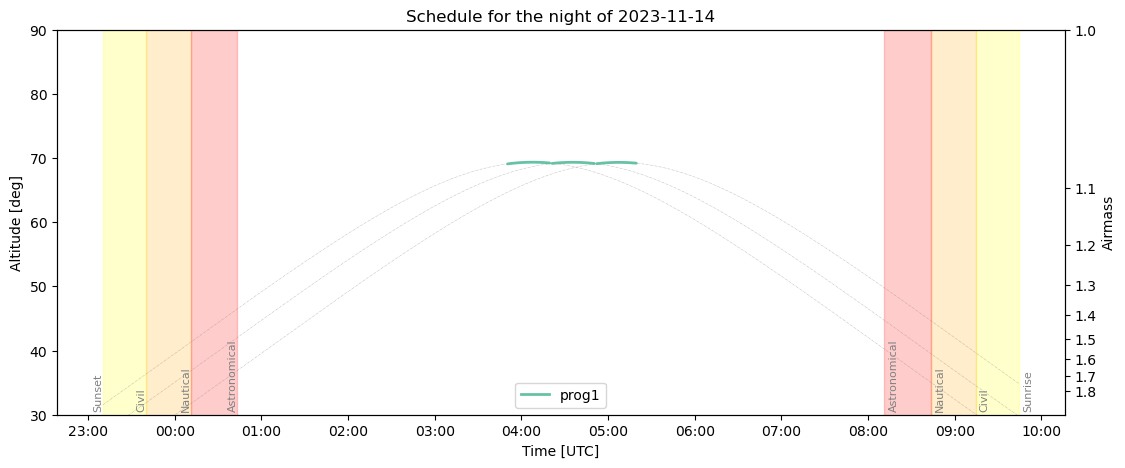

In [11]:
test_plan.plot()

We see that the scheduler has put the observations in the correct order to maximise the airmass of each.

### Full night schedule

Now let's create a full night schedule with stars from all programs and instruments

In [12]:
# Generate random star coordinates
np.random.seed(0)
ntars = 400

# Right ascension angle range that is visible from La Silla on the night of 2023-11-14 is roughly
# between 0 and 160, and 300 to 360 degrees
ra = np.random.uniform(300, 520, size=ntars) % 360
dec = -np.rad2deg(np.arcsin(np.random.uniform(0, 1, size=ntars)))

# We will initialize the observations start time at the start of the night
start_time = night.night_time_range[0].jd


# Create Observations objects
def create_tars_and_obs(prog, idx_range, merits):
    observations = []
    for i in range(idx_range[0], idx_range[1]):
        # Get the coordinates for the target
        coord = SkyCoord(ra[i], dec[i], unit="deg")
        # Create the Target object with a random priority
        target = Target(f"Target{i}", prog, coord, np.random.randint(0, 4))
        # Add the merits to the target
        target.add_merits(merits)

        # Create the observation
        exposure_time = 900 / 86400  # 900 seconds in units of days
        observation = Observation(target, exposure_time)
        observations.append(observation)
    return observations

Now lets create the Observations for each program. Let's assume that prog1 and prog2 need their targets to be observed at a maximum airmass of 1.5 as they need a good SNR. In contrast, prog3, prog4, and prog5 are not that sensitive to SNR and allows their targets to be observed up to an airmass of 1.8.

In [13]:
obs_prog1 = create_tars_and_obs(prog1, (0, 20), merits1)
obs_prog2 = create_tars_and_obs(prog2, (20, 40), merits1)
obs_prog3 = create_tars_and_obs(prog3, (40, 60), merits2)
obs_prog4 = create_tars_and_obs(prog4, (60, 80), merits2)
obs_prog5 = create_tars_and_obs(prog5, (80, 100), merits2)

all_obs = obs_prog1 + obs_prog2 + obs_prog3 + obs_prog4 + obs_prog5

## Scheduling the night

We have set up everything we need to now create the night sschedule based on the observations we created.

To do this we will initialize a Scheduler object from the `scopes.scheudler` module. To start we will use the simple generateQ scheduler which works based on a simple greedy search algorithms which works sequentially from the beginning of the night and always chooses the best scoring observation as the next observation to do.

In [44]:
# Initialize the scheduler
# Leaving the plan_start_time as None will set it to the start of the observable night
gQ_scheduler = scheduler.generateQ(night, all_obs)

Preparing observations for scheduling...


  0%|          | 0/100 [00:00<?, ?it/s]

Creating the Plan...
Done!


In [62]:
# Run the scheduler and create the plan
plan = gQ_scheduler.run(max_plan_length=10, K=5)

Creating the Plan...
Done!


In [63]:
plan.print_stats()

Length = 10
Score = 1.104412
Evaluation = 0.323259
Overhead time = 0:24:15.524983
Overhead ratio = 0.16172
Observation time = 2:30:00
Observation ratio = 0.29270


In [64]:
print(plan)

Plan for the night of 2023-11-14 (Times in UTC)
--------------------------------------------------

#     Program ID  Target              Start time   (Exp time)  Comment for the observer                
 1:   prog1 CAR   Target14            00:11:01     (0:15:00)                                           
 2:   prog5 BIKE  Target97            00:29:19     (0:15:00)                                           
 3:   prog5 BIKE  Target82            00:44:48     (0:15:00)                                           
 4:   prog1 CAR   Target15            01:03:02     (0:15:00)                                           
 5:   prog5 BIKE  Target92            01:21:37     (0:15:00)                                           
 6:   prog3 CAR   Target54            01:39:56     (0:15:00)                                           
 7:   prog3 CAR   Target48            01:58:04     (0:15:00)                                           
 8:   prog3 CAR   Target57            02:16:21     (0:15:00)        

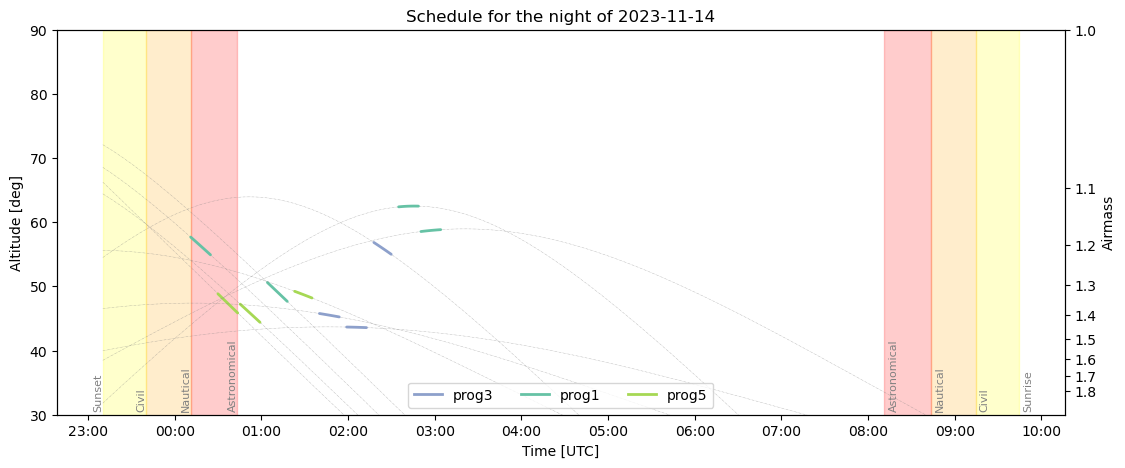

In [65]:
plan.plot()

## Test different schedulers

Let's try some other type of scheduling algorithms. These can be created customly by creating a new class that inherits from the base `Scheduler` class and includes a `run()` method that creates a Plan from the provided list of observations.

Here we will test the Dynamic Programming Planner (`DPPlanner`) and the `BeamSearchPlanner` schedulers.

### Dynamic Programming Planner (`DPPlanner`)

In [66]:
# Initialize the scheduler
# Leaving the plan_start_time as None will set it to the start of the observable night
dp_scheduler = scheduler.DPPlanner(night, all_obs)

Preparing observations for scheduling...


  0%|          | 0/100 [00:00<?, ?it/s]

In [68]:
# Run the scheduler and create the plan
plan_dp = dp_scheduler.run(max_plan_length=10, K=2)

In [69]:
plan_dp.print_stats()

Length = 10
Score = 1.103675
Evaluation = 0.323043
Overhead time = 0:24:53.164931
Overhead ratio = 0.16591
Observation time = 2:30:00
Observation ratio = 0.29270


In [70]:
print(plan_dp)

Plan for the night of 2023-11-14 (Times in UTC)
--------------------------------------------------

#     Program ID  Target              Start time   (Exp time)  Comment for the observer                
 1:   prog1 CAR   Target14            00:11:01     (0:15:00)                                           
 2:   prog5 BIKE  Target97            00:29:19     (0:15:00)                                           
 3:   prog5 BIKE  Target82            00:44:48     (0:15:00)                                           
 4:   prog1 CAR   Target15            01:03:02     (0:15:00)                                           
 5:   prog5 BIKE  Target92            01:21:37     (0:15:00)                                           
 6:   prog3 CAR   Target54            01:39:56     (0:15:00)                                           
 7:   prog3 CAR   Target57            01:55:51     (0:15:00)                                           
 8:   prog1 CAR   Target9             02:13:56     (0:15:00)        

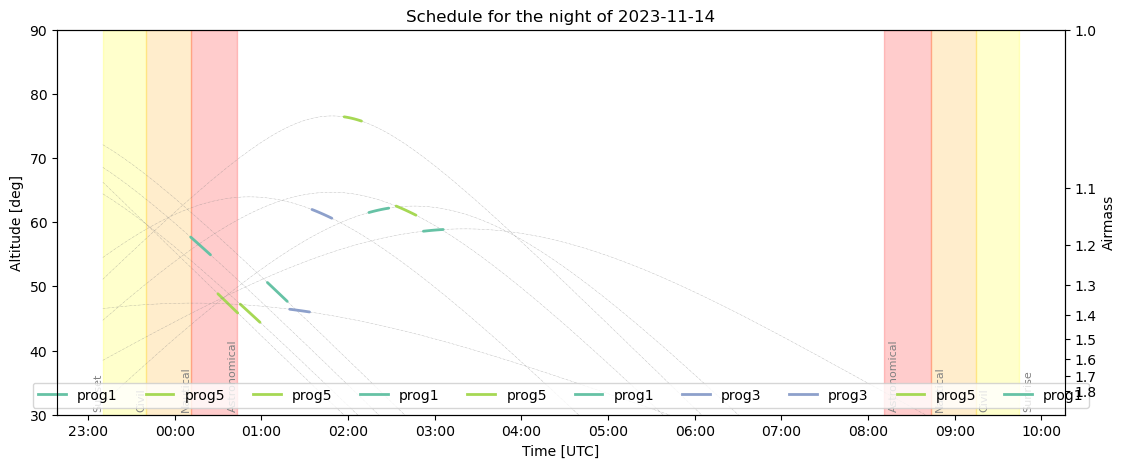

In [43]:
plan_dp.plot()

### Beam Search Planner (`BeamSearchPlanner`)

The BeamSearchPlanner algorithm can be visualized as navigating a decision tree where each node represents a potential observation plan, and each branch signifies adding an observation. Starting from the root (an empty plan), the algorithm explores various branches, but instead of examining every possible path, it employs a "beam" strategy to keep only the top K most promising branches at each level, effectively pruning the rest. This selective exploration ensures that the tree does not grow too large and unwieldy, focusing computational resources on extending only the most promising plans. As the algorithm progresses down the tree, it continuously evaluates and updates the best plan based on a scoring system, until it either reaches the maximum plan length or no further promising branches exist, culminating in the most optimal schedule of observations within the given constraints.

In [14]:
# Initialize the scheduler
# Leaving the plan_start_time as None will set it to the start of the observable night
bs_scheduler = scheduler.BeamSearchPlanner(night, all_obs)

Preparing observations for scheduling...


  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
# Run the scheduler and create the plan
bs_plan = bs_scheduler.run(max_plan_length=10, K=5)

In [20]:
bs_plan.print_stats()

Length = 10
Score = 1.098124
Evaluation = 0.321418
Overhead time = 0:22:32.282855
Overhead ratio = 0.15025
Observation time = 2:30:00
Observation ratio = 0.29270


In [21]:
print(bs_plan)

Plan for the night of 2023-11-14 (Times in UTC)
--------------------------------------------------

#     Program ID  Target              Start time   (Exp time)  Comment for the observer                
 1:   prog5 BIKE  Target99            00:11:01     (0:15:00)                                           
 2:   prog1 CAR   Target14            00:29:22     (0:15:00)                                           
 3:   prog1 CAR   Target15            00:44:44     (0:15:00)                                           
 4:   prog3 CAR   Target54            01:00:36     (0:15:00)                                           
 5:   prog5 BIKE  Target92            01:18:56     (0:15:00)                                           
 6:   prog3 CAR   Target57            01:37:39     (0:15:00)                                           
 7:   prog5 BIKE  Target90            01:58:41     (0:15:00)                                           
 8:   prog1 CAR   Target9             02:17:01     (0:15:00)        

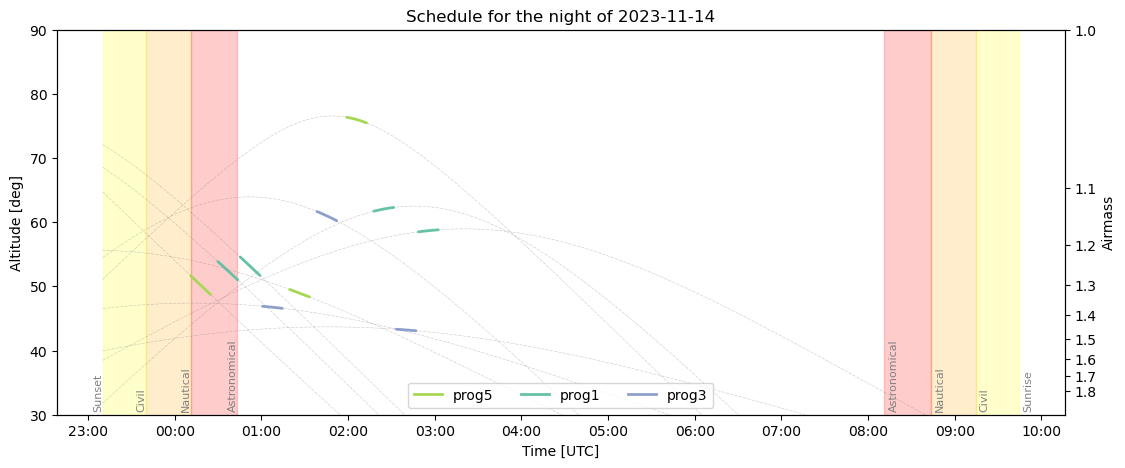

In [22]:
bs_plan.plot()